## Load libraries 

In [30]:
# Data analysis
import pandas as pd
import numpy as np

# ML
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_recall_fscore_support, precision_score, recall_score
from sklearn.decomposition import PCA 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
# from xgboost import plot_importance

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Miscs
import glob, os
from tqdm import tqdm, tqdm_notebook

In [34]:
import jupyter
jupyter.__version__

'1.0.0'

In [33]:
import sklearn
sklearn.__version__

'0.21.3'

In [31]:
xgb.__version__

'0.90'

In [15]:
import warnings
warnings.filterwarnings("ignore")

## Load data

### First time only: create one single csv file

In [4]:
%%time
path = './csvs/'
all_files = glob.glob(os.path.join(path, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files))

CPU times: user 3min 33s, sys: 887 ms, total: 3min 33s
Wall time: 3min 38s


In [5]:
df.to_csv("./data/20200216.csv", index=False)

### Load a single csv file

In [5]:
%%time
df = pd.read_csv("./data/20200216.csv")

CPU times: user 1.77 s, sys: 62.7 ms, total: 1.83 s
Wall time: 1.83 s


In [6]:
df.shape

(430, 7512)

Label-encode the target

In [7]:
df['label'] = np.where(df['label'] == 'EOG', 1, 0)

## ML

In [8]:
features = [f"map_component_{i}" for i in range(10)]

### Some PCA

In [9]:
pca = PCA(n_components=2)

In [10]:
df_scaled = df.drop(columns=['label', 'name'])[features].copy()
scaler = StandardScaler()
scaler.fit(df_scaled.values)
df_scaled = scaler.transform(df_scaled)
projected = pca.fit_transform(df_scaled)

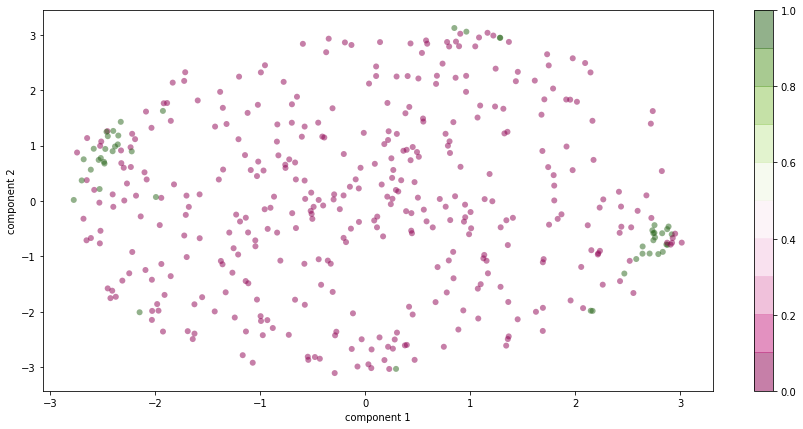

In [11]:
plt.figure(figsize=(15,7))
plt.scatter(projected[:, 0], projected[:, 1],
            c=df['label'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('PiYG', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Visually, Non-EOG and EOG points are not linearly separable

### Feature engineering

TODO...

### Data preparation

In [12]:
X = df.drop(columns=['label', 'name']).copy()
y = df['label'].copy()

### Model comparison

In [26]:
%%time
# Define models
svm_params = {}
xgb_params = {}
rf_params = {}
et_params = {}
# lr_params = {}
estimators = [
    ('Random forest', RandomForestClassifier(n_jobs=-1,random_state=2020,  **rf_params)),
    ('Extra trees', ExtraTreesClassifier(n_jobs=-1,random_state=2020,  **et_params)),
    ('Extreme gradient boosting', xgb.XGBClassifier(n_jobs=-1,random_state=2020,  **xgb_params)),
#     ('lr', LogisticRegression(random_state=2020,)),
    ('SVM', SVC(random_state=2020, **svm_params)),
]

# Cross validation: 3 folds
cv = StratifiedKFold(n_splits=3, shuffle=True,)
model_stats = pd.DataFrame(columns=['take', 'model', 'accuracy', 'precision', 'recall', 'f1'])
for i in tqdm(range(10)): # Run the experiment 10 times, each time the data will be split differently
    for name, clf in estimators:
        # Define pipeline
        pipe = Pipeline([
            ('scale', StandardScaler()),
            ('classifier', clf)
        ], verbose=False)
        score = cross_validate(pipe, X[features], y, scoring=['f1', 'accuracy', 'recall', 'precision'], cv=cv, n_jobs=-1, verbose=False)
        model_stats = model_stats.append({
            'take': i+1,
            'model': name,
            'accuracy': score['test_accuracy'].mean(),
            'precision': score['test_precision'].mean(),
            'recall': score['test_recall'].mean(),
            'f1': score['test_f1'].mean()
        },ignore_index=True)

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

CPU times: user 860 ms, sys: 29.2 ms, total: 889 ms
Wall time: 12.9 s


In [27]:
model_stats.groupby('model').mean().sort_values(by=['f1'], ascending=[False])

,accuracy,precision,recall,f1
model,,,,
Extra trees,0.970463,0.932478,0.801838,0.858136
SVM,0.955813,0.804479,0.819730,0.806283
Extreme gradient boosting,0.953717,0.852081,0.732353,0.781951
Random forest,0.954194,0.887928,0.692279,0.772620


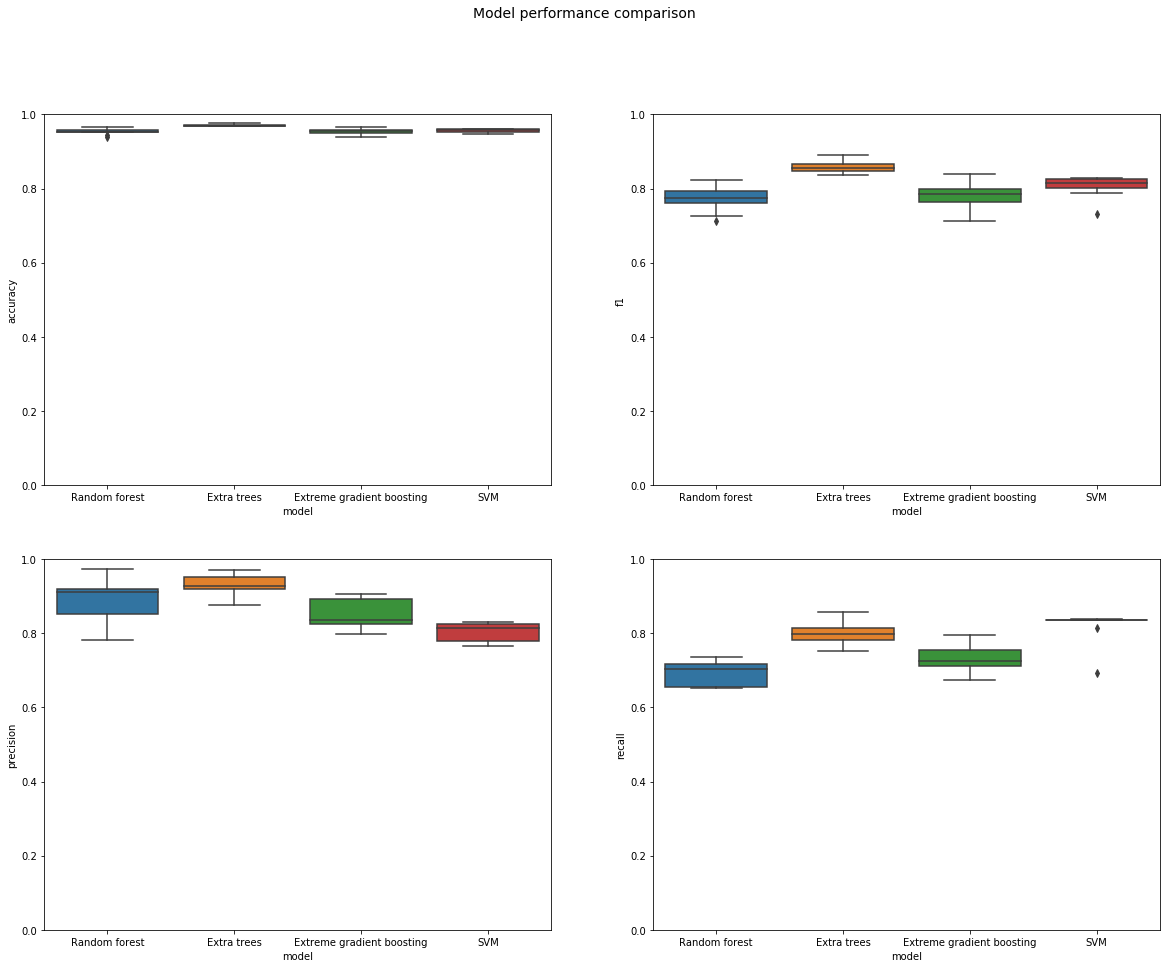

In [29]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
fig.suptitle('Model performance comparison', fontsize=14)
sns.boxplot(x='model', y='accuracy', data=model_stats, ax=ax[0][0])
sns.boxplot(x='model', y='f1', data=model_stats, ax=ax[0][1])
sns.boxplot(x='model', y='precision', data=model_stats, ax=ax[1][0])
sns.boxplot(x='model', y='recall', data=model_stats, ax=ax[1][1])
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylim(0, 1)
# ax.set_ylabel('REcall score')